In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torchdiffeq import odeint

import matplotlib.pyplot as plt


In [2]:
data=pd.read_csv('../data/VCB.csv')

In [16]:
data.head(10)

,Unnamed: 0.1,Unnamed: 0,time,open,high,low,close,volume
0,0,0,2018-01-02,22.98,23.58,22.81,23.41,2801720
1,1,1,2018-01-03,23.62,23.71,23.20,23.37,1843870
2,2,2,2018-01-04,23.24,23.58,23.11,23.58,1990040
3,3,3,2018-01-05,23.45,23.45,22.94,22.98,2045200
4,4,4,2018-01-08,22.98,23.62,22.56,23.58,2071140
5,5,5,2018-01-09,23.83,24.90,23.20,24.90,2853160
6,6,6,2018-01-10,24.81,25.20,24.39,24.69,2842830
7,7,7,2018-01-11,24.47,25.03,24.35,25.03,1766240
8,8,8,2018-01-12,25.03,25.28,24.69,24.69,2525840
9,9,9,2018-01-15,24.69,25.54,24.26,25.54,2061850


C:\Users\DELL\AppData\Local\Temp\ipykernel_1912\1121445975.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


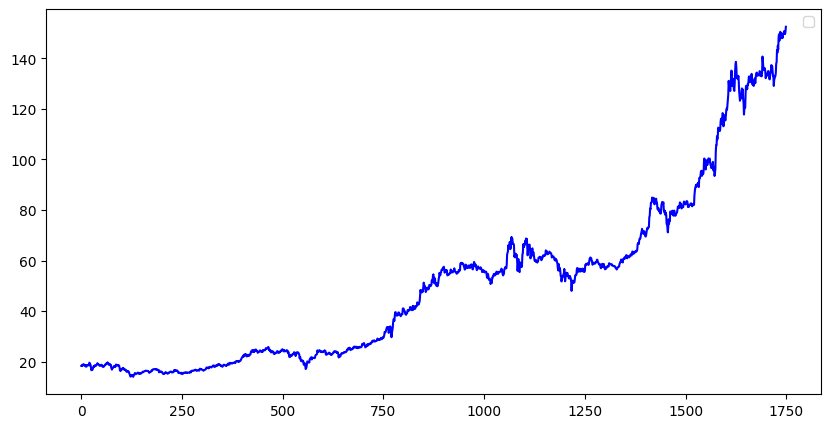

In [3]:
plt.figure(figsize=(10, 5))  #
plt.plot(data[['close']],color='blue')   #
plt.legend()
plt.show()

In [3]:
def process_data(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    #Lấy cột Close
    data=data[['close']]

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=False)

    # Khởi tạo scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit scaler trên tập huấn luyện và transform cả train lẫn test
    train_scaled = scaler.fit_transform(x_train)
    test_scaled = scaler.transform(x_test)

    #Tạo vòng lặp giá trị, lấy 50 ngày trong quá khứ để dự đoán ngày tiếp theo
    x_train = []
    y_train = []
    for i in range(60, len(train_scaled)):
        x_train.append(train_scaled[i-60:i, 0])
        y_train.append(train_scaled[i, 0])

    x_test = []
    y_test = []
    for i in range(60, len(test_scaled)):
        x_test.append(test_scaled[i-60:i, 0])
        y_test.append(test_scaled[i, 0])

    #Chuyển dạng list sang dạng mảng numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    #Xếp dữ liệu thành mảng 1 chiều
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, test_scaled

In [4]:
#Model NODE
class ODEfunc(nn.Module):
    def __init__(self, input_size):
        super(ODEfunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),        #Kích thước đầu vào (số tính năng)
            nn.Tanh(),
            nn.Linear(64, input_size)
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODE(nn.Module):
    def __init__(self, odefunc, num_feature):
        super(NeuralODE, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0,1]).float()


    def forward(self, x):
        out = odeint(self.odefunc, x, self.integration_time)
        out = out[1]
        out = out[:,-1,:]
        return out


def train_NeuralODE(model, x_train, y_train,x_test, y_test ,epochs=100, lr=0.01, patience=10):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    y_train = y_train.squeeze()
    y_test = y_test.squeeze()

    best_val_loss = float('inf')
    best_model = None
    patience_count = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()     #Xóa gradients từ bước trước
        prediction = model(x_train).squeeze()
        loss = criterion(prediction, y_train)
        loss.backward()
        optimizer.step()    #Cập nhật tham số mô hình

        model.eval()
        with torch.no_grad():
            val_prediction = model(x_test).squeeze()
            val_loss = criterion(val_prediction, y_test)

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model = model.state_dict()
            patience_count = 0
        else:
            patience_count +=1

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Training loss: {loss.item()}, Val loss: {val_loss.item()}')

        if patience_count > patience:
            print(f'Early stopping at epoch {epoch}')
            break

    if model is not None:
        model.load_state_dict(best_model)

    return model

In [12]:
x_train, y_train, x_test, y_test, scaler, test_scaled = process_data(data)

In [ ]:
#MWG
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.13111619651317596, Val loss: 0.014612268656492233
Epoch 10, Training loss: 0.02296358160674572, Val loss: 0.025187913328409195
Epoch 20, Training loss: 0.006584411486983299, Val loss: 0.016339052468538284
Epoch 30, Training loss: 0.0004338783910498023, Val loss: 0.0009279553196392953
Epoch 40, Training loss: 0.0003375491651240736, Val loss: 0.0004928959533572197
Early stopping at epoch 40


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [ ]:
#MSFT 30ngay
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.024089546874165535, Val loss: 0.028995737433433533
Epoch 10, Training loss: 0.008472835645079613, Val loss: 0.0054474626667797565
Epoch 20, Training loss: 0.0013718187110498548, Val loss: 0.0006061333697289228
Epoch 30, Training loss: 0.0003062496252823621, Val loss: 0.005940860137343407
Early stopping at epoch 36


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [64]:
#MSFT 50ngay
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.0751710906624794, Val loss: 0.0017397193005308509
Epoch 10, Training loss: 0.0037074938882142305, Val loss: 0.039054661989212036
Epoch 20, Training loss: 0.0038929199799895287, Val loss: 0.0006286893622018397
Epoch 30, Training loss: 0.0023350506089627743, Val loss: 0.007765172049403191
Early stopping at epoch 32


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [ ]:
#MSFT 60ngay
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.0006933351396583021, Val loss: 0.10298845171928406
Epoch 10, Training loss: 0.0011303190840408206, Val loss: 0.00040472199907526374
Epoch 20, Training loss: 0.0020419086795300245, Val loss: 0.0033560623414814472
Early stopping at epoch 29


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [ ]:
#VCB
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.006169696804136038, Val loss: 0.034517884254455566
Epoch 10, Training loss: 0.00028253145865164697, Val loss: 0.0019435847643762827
Epoch 20, Training loss: 0.0011665578931570053, Val loss: 0.00034209288423880935
Epoch 30, Training loss: 0.0007440681220032275, Val loss: 0.0008797679329290986
Early stopping at epoch 35


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [12]:
#FPT
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.0805840939283371, Val loss: 0.026640063151717186
Epoch 10, Training loss: 0.004200115334242582, Val loss: 0.01852131262421608
Epoch 20, Training loss: 0.004879008047282696, Val loss: 0.006177226081490517
Epoch 30, Training loss: 0.0026351213455200195, Val loss: 0.0009822718566283584
Epoch 40, Training loss: 0.0009600210469216108, Val loss: 0.0038678119890391827
Early stopping at epoch 40


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [ ]:
#BID
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.008315464481711388, Val loss: 0.10319236665964127
Epoch 10, Training loss: 0.006555645726621151, Val loss: 0.008971314877271652
Epoch 20, Training loss: 0.0009333206689916551, Val loss: 0.003979846369475126
Epoch 30, Training loss: 0.000816637184470892, Val loss: 0.0015810029581189156
Early stopping at epoch 39


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [ ]:
#HPG
node_model = NeuralODE(ODEfunc(1), 1)
train_NeuralODE(node_model, x_train, y_train,x_test, y_test)

Epoch 0, Training loss: 0.004134823102504015, Val loss: 0.07788638770580292
Epoch 10, Training loss: 0.011701594106853008, Val loss: 0.0069753811694681644
Early stopping at epoch 16


NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [ ]:
torch.save(node_model, '../model/NODE-MSFT-30.pth')

In [5]:
node_model = torch.load('../model/NODE-VCB.pth', weights_only=False)

In [13]:
print(node_model)

NeuralODE(
  (odefunc): ODEfunc(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [ ]:
test_tensor = torch.from_numpy(x_test).float()
predict = node_model(test_tensor).detach().numpy()
predict = predict.squeeze()

In [ ]:
#MWG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.022201260537576126
MAE:  0.017753484869537324
R-squared:  0.9824764266149257


In [ ]:
#MSFT 60ngay
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.020905756638764945
MAE:  0.016606685486379832
R-squared:  0.9430842487680049


In [ ]:
#FPT
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.03389519772778161
MAE:  0.02754033101945248
R-squared:  0.9926547461353687


In [ ]:
#VCB
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.017291235849080756
MAE:  0.0137379510508696
R-squared:  0.8934251123986514


In [ ]:
#BID
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.03707334541131698
MAE:  0.0310996611410516
R-squared:  0.9132744975381127


In [ ]:
#HPG
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.01244264782605394
MAE:  0.009453729191755534
R-squared:  0.9178179233905703


In [ ]:
prediction_test_price = scaler.inverse_transform(predict.reshape(-1, 1))
actual_test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

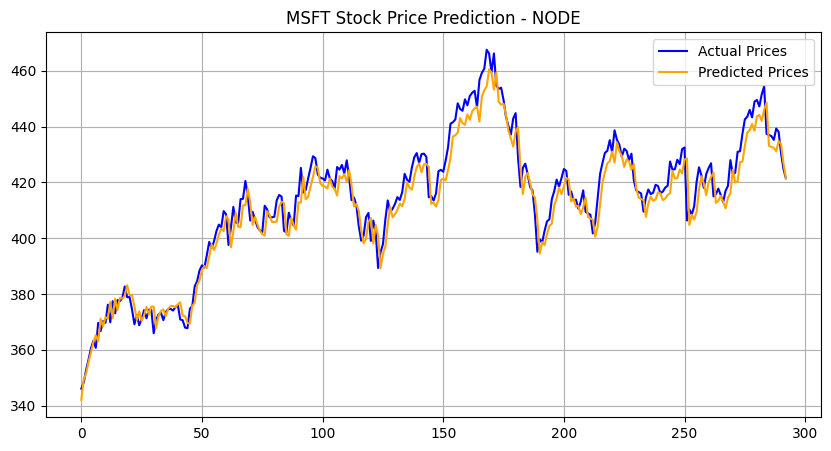

In [80]:
#Vẽ biểu đồ MSFT 60ngay

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

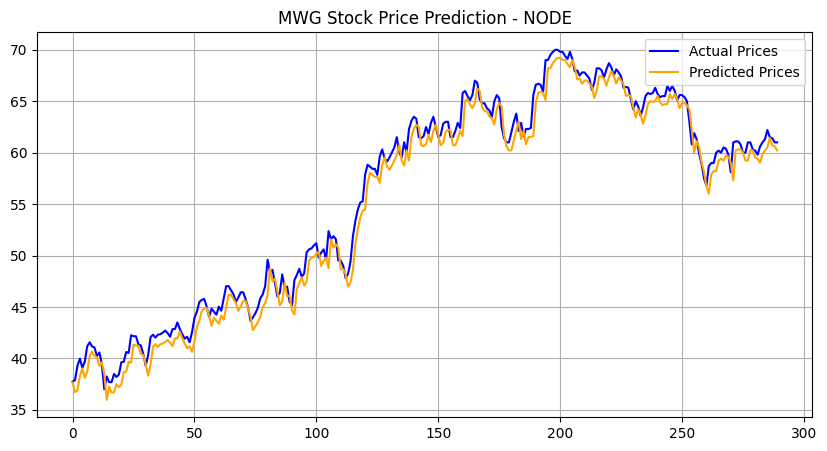

In [86]:
#Vẽ biểu đồ 

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

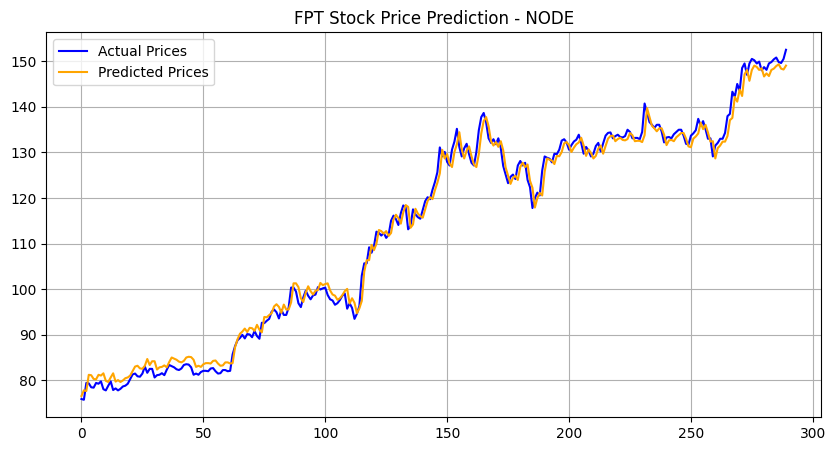

In [65]:
#Vẽ biểu đồ 

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

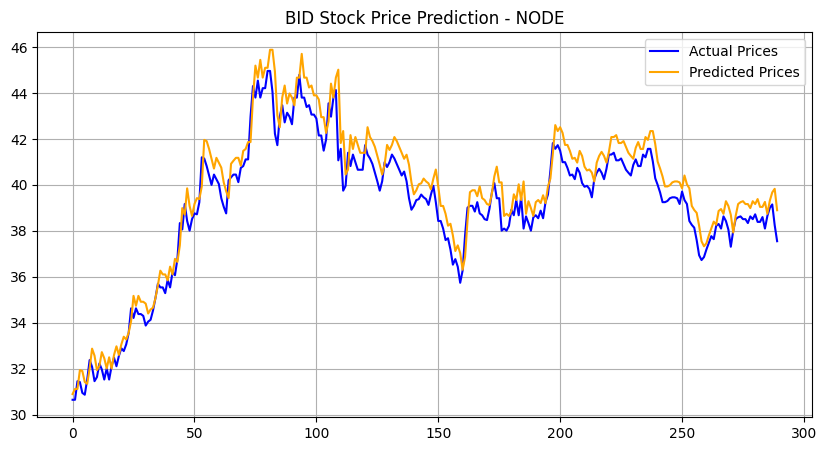

In [58]:
#Vẽ biểu đồ BID

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

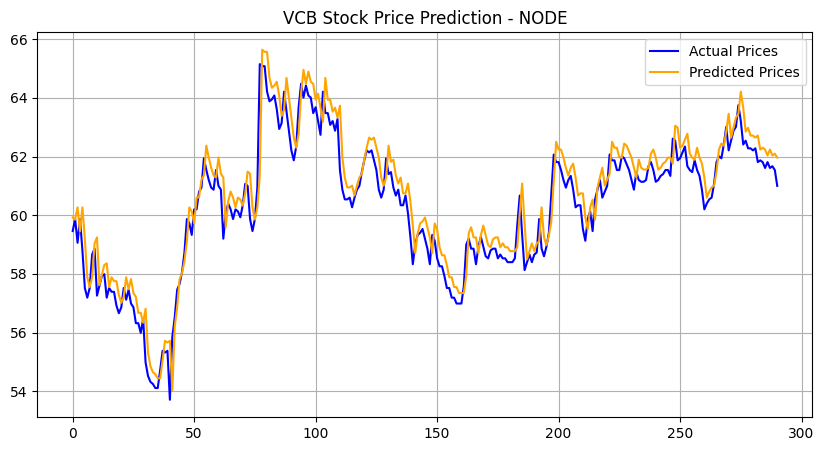

In [92]:
#Vẽ biểu đồ 

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()

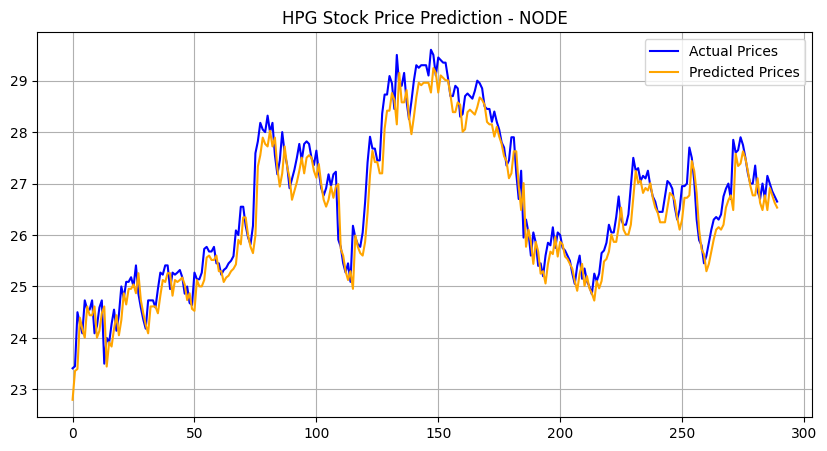

In [10]:
#Vẽ biểu đồ HPG

plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - NODE')
plt.legend()
plt.grid(True)
plt.show()